# **Summary**
This notebook will fit a Random Forest model to predict the termination rate and find important factors that lead to termination.

- Can we predict who is going to terminate and who isn't? What level of accuracy can we achieve on this?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, shapiro, levene
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, make_scorer,roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import mstats
from sklearn.feature_selection import RFE
from sklearn.tree import plot_tree

pd.set_option('display.max_columns', None)
model_df = pd.read_csv("model_HRDataset.csv")
df=pd.read_csv("cleaned_HRDataset.csv")

In [2]:
model_df.head()

,MarriedID,MaritalStatusID,GenderID,DeptID,PerfScoreID,Salary,Termd,PositionID,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,Age,Tenure,PerformanceStandard
0,0,0,1,5,4,11.043034,0,19,22.0,LinkedIn,Exceeds,4.60,5,0.00000,0.0,0.693147,36,8.490075,1
1,1,1,1,3,3,11.556349,1,27,4.0,Indeed,Fully Meets,4.96,3,1.94591,0.0,2.890372,44,1.215606,0
2,1,1,0,5,3,11.081465,1,20,20.0,LinkedIn,Fully Meets,3.02,3,0.00000,0.0,1.386294,31,1.223819,1
3,1,1,0,5,3,11.082019,0,19,16.0,Indeed,Fully Meets,4.84,5,0.00000,0.0,2.772589,31,11.980835,1
4,0,2,0,5,3,10.836163,1,19,39.0,Google Search,Fully Meets,5.00,4,0.00000,0.0,1.098612,30,5.158111,1


In [3]:
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Age,Tenure,DiversityStatus,DeptAverageSalary,Salary_Dept_Ratio,DeptAveragePerfScore,PerformanceStandard,DaysSinceLastReview
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,0,19,Production Technician I,MA,1960,1983-07-10,M,Single,US Citizen,No,White,2011-07-05,NaN,Still Employed,Active,Production,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,2019-01-17,0,1,36,8.490075,Non-Diverse,59967.788462,1.042326,2.980769,1,348
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,1,27,Sr. DBA,MA,2148,1975-05-05,M,Married,US Citizen,No,White,2015-03-30,2016-06-16,Career Change,Voluntarily Terminated,IT/IS,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2016-02-24,0,17,44,1.215606,Non-Diverse,97064.640000,1.075953,3.060000,0,113
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,1,20,Production Technician II,MA,1810,1988-09-19,F,Married,US Citizen,No,White,2011-07-05,2012-09-24,Attendance,Voluntarily Terminated,Production,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,2012-05-15,0,3,31,1.223819,Non-Diverse,59967.788462,1.083165,2.980769,1,132
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,0,19,Production Technician I,MA,1886,1988-09-27,F,Married,US Citizen,No,White,2008-01-07,NaN,Still Employed,Active,Production,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,2019-01-03,0,15,31,11.980835,Non-Diverse,59967.788462,1.083765,2.980769,1,362
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,1,19,Production Technician I,MA,2169,1989-09-08,F,Divorced,US Citizen,No,White,2011-07-11,2016-09-06,Education,Voluntarily Terminated,Production,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2016-02-01,0,2,30,5.158111,Non-Diverse,59967.788462,0.847538,2.980769,1,218


In [4]:
def model_metrics(preds, y):
    print(f'Accuracy: {accuracy_score(preds, y)}')
    print(f'Precision: {precision_score(preds, y)}')
    print(f'Recall: {recall_score(preds, y)}')
    print(f'F1: {f1_score(preds, y)}')
    print(f'ROC_AUC: {roc_auc_score(preds, y)}')

# **1. Fit RandomForest Model**

In [5]:
X=model_df.drop('Termd', axis=1)
y=model_df['Termd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_features = ['RecruitmentSource', 'PerformanceScore']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', [col for col in X.columns if col not in categorical_features]),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

y_pred = rf_model.predict(X_test_encoded)
model_metrics(y_pred, y_test)

Accuracy: 0.8888888888888888
Precision: 0.7142857142857143
Recall: 0.9375
F1: 0.8108108108108109
ROC_AUC: 0.9049202127659575


# **2. Visualizations**

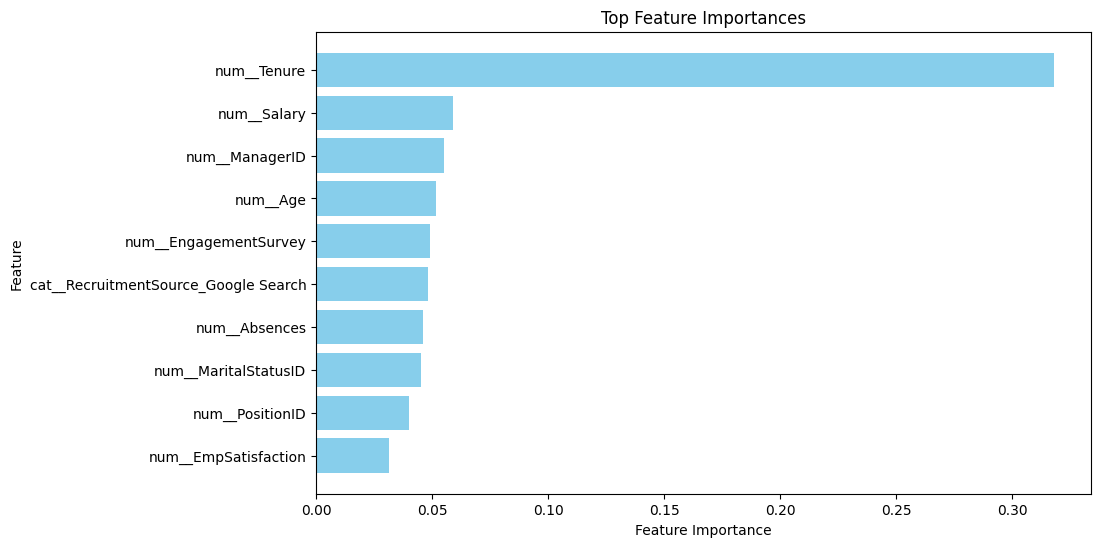

In [6]:
def plot_feature_importance(model, feature_names, preprocessor, top_n=None):
    importances = model.feature_importances_

    encoded_feature_names = preprocessor.get_feature_names_out()

    importance_df = pd.DataFrame({
        'Feature': encoded_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(rf_model, X.columns, preprocessor, top_n=10)

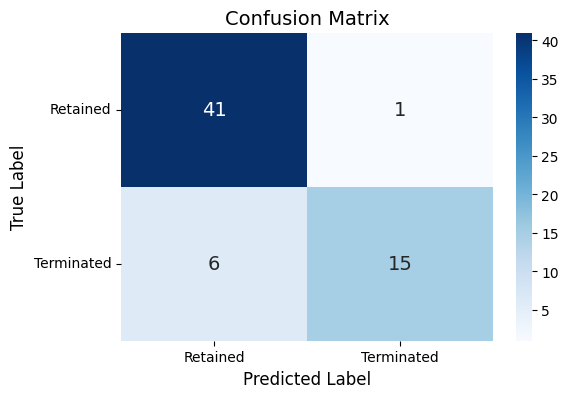

In [7]:
y_pred = rf_model.predict(X_test_encoded)
y_proba = rf_model.predict_proba(X_test_encoded)[:, 1]

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues',
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(ticks=[0.5,1.5], labels=['Retained', 'Terminated'])
plt.yticks(ticks=[0.5,1.5], labels=['Retained', 'Terminated'], rotation=0)
plt.show()

# **3. Hyperparameter Tuning**

In [8]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',  # Focus on AUC for class imbalance
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nBest Parameters:", grid_search.best_params_)
model_metrics(y_pred, y_test)
feature_importances = best_rf.named_steps['classifier'].feature_importances_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits

Best Parameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Accuracy: 0.8888888888888888
Precision: 0.7142857142857143
Recall: 0.9375
F1: 0.8108108108108109
ROC_AUC: 0.9049202127659575


Hyptertuning provides no added benefit with no improvement to the results.

# **4. Predictive Model**

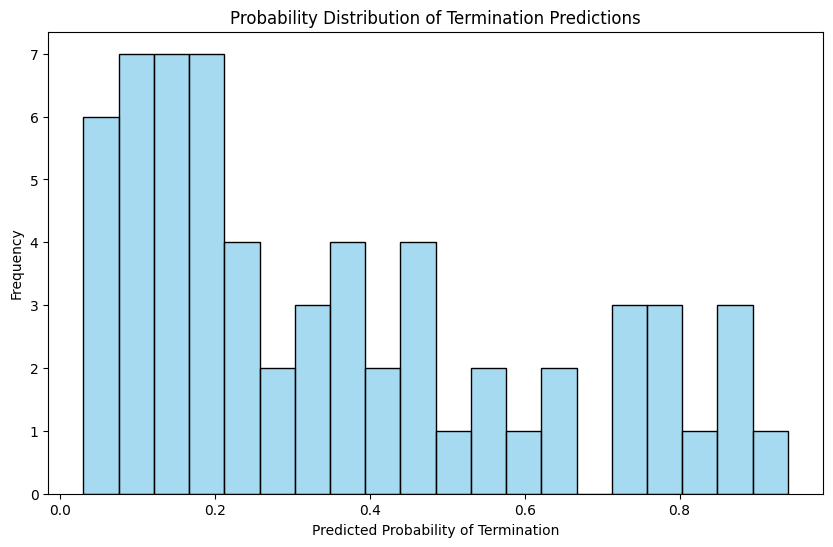

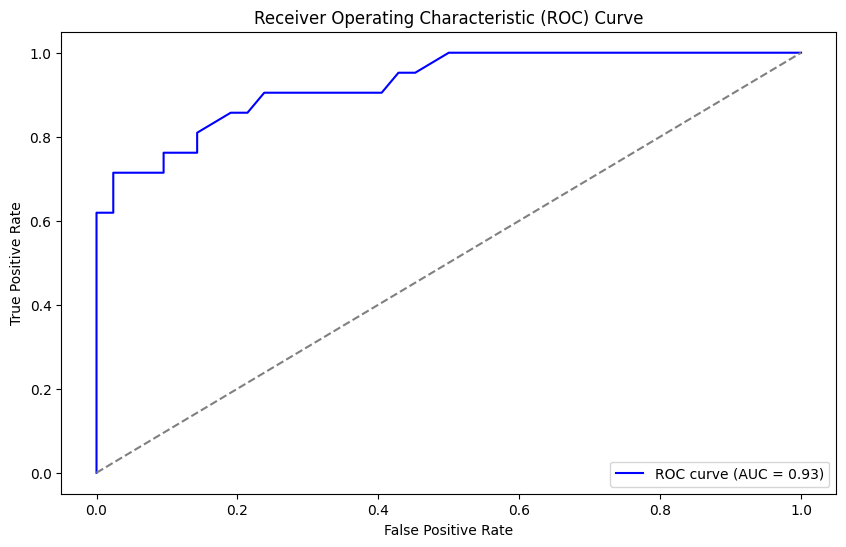

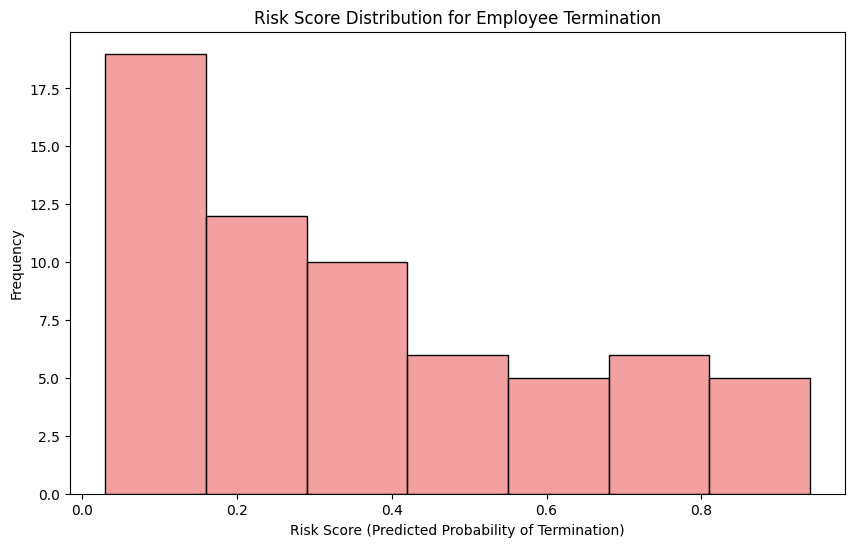

   Employee Index  Risk Score   Risk Label
0             185        0.56  Medium Risk
1              34        0.21     Low Risk
2             310        0.19     Low Risk
3             139        0.03     Low Risk
4             150        0.25     Low Risk


In [9]:
y_prob = rf_model.predict_proba(X_test_encoded)[:, 1]

# 1. Probabilistic Predictions Visualization (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(y_prob, bins=20, color='skyblue')
plt.title('Probability Distribution of Termination Predictions')
plt.xlabel('Predicted Probability of Termination')
plt.ylabel('Frequency')
plt.show()

# 2. ROC Curve for Model Evaluation
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3. Risk Modeling: Risk Scores
risk_scores = y_prob
risk_labels = ['Low Risk' if score < 0.3 else 'Medium Risk' if score < 0.7 else 'High Risk' for score in risk_scores]

risk_df = pd.DataFrame({
    'Employee Index': X_test.index,
    'Risk Score': risk_scores,
    'Risk Label': risk_labels
})

# 4. Risk Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(risk_scores, color='lightcoral')
plt.title('Risk Score Distribution for Employee Termination')
plt.xlabel('Risk Score (Predicted Probability of Termination)')
plt.ylabel('Frequency')
plt.show()

print(risk_df.head())

# **5. Conclusion**

**Baseline metrics:**
- Accuracy: 0.6666666666666666
- Precision: 0.38095238095238093
- Recall: 0.5
- F1: 0.43243243243243246
- ROC_AUC: 0.6117021276595744

**Compared to the baseline metrics, the official Random Forest model has made considerable progress as a predictive model with the metrics:**
- Accuracy: 0.8888888888888888
- Precision: 0.7142857142857143
- Recall: 0.9375
- F1: 0.8108108108108109
- ROC_AUC: 0.9049202127659575

F1-score and ROC AUC will be the main metrics to evaluate this model to account for the class imbalance. With an **ROC AUC of 90.5%**, the model excels at ranking employees by turnover risk (e.g., distinguishing high-risk vs. low-risk employees). The **F1-score of 81.1%** indicates a good balance between precision and recall. However a **lower precision of 71.4%** means **28.6% of flagged "at-risk" employees are false positives (~3 in 10 flagged employees are false positives).** While this ensures few actual turnover cases are missed, it may lead to unnecessary retention costs if overacted upon. With **93.8% recall**, HR can confidently use this model to:
- Prioritize stay interviews for high-risk employees.
- Allocate retention bonuses strategically.

Using the predictive power of the model a risk score was assigned to the employees to indicate if they were at risk of termination. Some key insights of the model:
1. **Majority are low risk** with the highest bar being in the 0.0 to 0.2 range, showing  that most employees have a low predicted probability of termination.
This is a good sign as the model identifies that the workforce, overall, is stable.
2. **Smaller medium/high-risk population**, fewer employees have risk scores between 0.4 and 0.9, indicating potential turnover. Because these are the employees most at risk intervention methods should be conducted and may need follow-up, especially those above 0.7 (high risk).

Overall, this model can be used to flag and proactively engage medium- to high-risk employees with interventions like check-ins, development plans, or manager conversations while also determining resource allocation, where the company may focus HR and managerial attention on the top 10-20% most at-risk employees. It makes resource use more targeted and effective.


The top factors of determining or predicting termination status are:
- Tenure: The amount of time an employee has stayed active within in the company.
- Salary
- ManagerID: The manager an employee worked under.
- Age
- EngagementSurvey

